In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import curve_fit
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

In [2]:
def plotly_parameters_combine(df, html_filename='parameters_over_time.html'):
    target_columns = ['SA (deg)', 'FZ (lb)', 'P (psi)' ,'V (mph)', 'IA (deg)', 'SR (f)']
    num_rows = len(target_columns)

    fig = make_subplots(rows=num_rows, cols=1, subplot_titles=target_columns)
    
    time_column = df.columns[0]

    for i, column in enumerate(target_columns, start=1):
        fig.add_trace(go.Scatter(x=df[time_column], y=df[column], mode='lines', name=column),
                      row=i, col=1)
        fig.update_xaxes(title_text='', row=i, col=1)
        fig.update_yaxes(title_text="", row=i, col=1)
    
    fig.update_layout(
        title="Inputs Over Time",
        showlegend=True,
        height=800,
        width=1300,
        hovermode="x unified"
    )

    fig.write_html(html_filename)

In [3]:
def open_dat_file(file_path):
    with open(file_path, 'r') as dat_file:
            lines = dat_file.readlines()
            first_row = lines[0].strip()
            parameter_name = lines[1].strip().replace('\t', ' ')
            unit = lines[2].strip().replace('\t', ' ')

            parameter_name_list = parameter_name.split()
            unit_list = unit.split()

            column_names = [f'{param} ({unit})' for param, unit in zip(parameter_name_list, unit_list)]
        
    return pd.read_csv(file_path, delimiter='\t', skiprows=3, header=None, names=column_names)

In [4]:
def df_prepare(filepath, html_name):

    df = open_dat_file(filepath)
    plotly_parameters_combine(df, html_name)
    
    return open_dat_file(filepath)

In [5]:
def get_lat_fz_14psi(df):
    df_250 = df[(df['ET (s)'] <= 1505) & (df['ET (s)'] >= 1492) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_200 = df[(df['ET (s)'] <= 1539) & (df['ET (s)'] >= 1526) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_150 = df[(df['ET (s)'] <= 1573) & (df['ET (s)'] >= 1560) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_50 = df[(df['ET (s)'] <= 1606) & (df['ET (s)'] >= 1594) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    dataframes = [df_250, df_200, df_150, df_50]
    return dataframes

In [6]:
def get_lat_fz_8psi(df):
    df_250 = df[(df['ET (s)'] <= 121) & (df['ET (s)'] >= 108) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_200 = df[(df['ET (s)'] <= 155) & (df['ET (s)'] >= 142) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_150 = df[(df['ET (s)'] <= 188) & (df['ET (s)'] >= 176) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    df_50 = df[(df['ET (s)'] <= 222) & (df['ET (s)'] >= 210) & (df['SA (deg)'] >= -12) & (df['SA (deg)'] <= 12)]
    dataframes = [df_250, df_200, df_150, df_50]
    return dataframes

In [7]:
# # plot with sns
# def plot_lat_fz(df, get_lat_fz, title, label=['250lb','200lb','150lb','50lb']):
#     plt.figure(figsize=(8, 6))

#     sns.scatterplot(data=get_lat_fz(df)[0], x='SA (deg)', y='FY (lb)', label=label[0], s=2)
#     sns.scatterplot(data=get_lat_fz(df)[1], x='SA (deg)', y='FY (lb)', label=label[1], s=2)
#     sns.scatterplot(data=get_lat_fz(df)[2], x='SA (deg)', y='FY (lb)', label=label[2], s=2)
#     sns.scatterplot(data=get_lat_fz(df)[3], x='SA (deg)', y='FY (lb)', label=label[3], s=2)

#     plt.title(f'Test{title} 25mph 0deg')
#     plt.xlabel('SA (deg)')
#     plt.ylabel('FY (lb)')

#     plt.legend()

#     plt.show()

In [8]:
# plot with plotly
def plot_lat_fz(df, get_lat_fz, title, labels=['250lb', '200lb', '150lb', '50lb']):
    fig = px.scatter(title=f'Test {title} 25mph')
    
    for i, label in enumerate(labels):
        lat_fz_data = get_lat_fz(df)[i]
        fig.add_scatter(x=lat_fz_data['SA (deg)'], y=lat_fz_data['FY (lb)'], mode='markers', name=label, marker_size=2)

    fig.update_layout(
        xaxis_title='SA (deg)',
        yaxis_title='FY (lb)',
        showlegend=True,
    )

    fig.show()

# Exampel usage:
# labels = ['250lb','200lb','150lb','50lb']
# plot_lat_fz(results_2[8]['df'],get_lat_fz_14psi,8)
# plot_lat_fz(df_4_5,get_lat_fz_14psi,'4&5')
# plot_lat_fz(results_2[23]['df'],get_lat_fz_14psi,23,label=['250lb','350lb','150lb','50lb'])

In [9]:
def polynomial(x, *coefficients):
    return sum(coefficients[i] * x**i for i in range(len(coefficients)))

def polynomial_derivative(x, *coefficients):
    return sum(i * coefficients[i] * x**(i-1) for i in range(1, len(coefficients)))

In [10]:
def slope_at_zero(dataframes, degree = 3):

    curve_coefficients = []
    slopes_at_zero = []

    for i, dff in enumerate(dataframes):
        x = dff['SA (deg)']
        y = dff['FY (lb)']

        initial_guess = [1.0] * (degree + 1)
        coefficients, _ = curve_fit(polynomial, x, y, p0=initial_guess)
        coefficients[0] = 0.0

        slope_at_zero = polynomial_derivative(0, *coefficients)

        curve_coefficients.append(coefficients)
        slopes_at_zero.append(slope_at_zero)
        
        x_curve = np.linspace(x.min(), x.max(), 100)
        y_curve = polynomial(x_curve, *coefficients)
    
    return slopes_at_zero

In [11]:
def plot_fitted_data(dataframes, degree = 3, labels = ['250lb', '200lb', '150lb', '50lb'], p=8):

    plt.figure(figsize=(10, 6))

    for i, dff in enumerate(dataframes):
        x = dff['SA (deg)']
        y = dff['FY (lb)']

        initial_guess = [1.0] * (degree + 1)
        coefficients, _ = curve_fit(polynomial, x, y, p0=initial_guess)
        coefficients[0] = 0.0

        x_curve = np.linspace(x.min(), x.max(), 100)
        y_curve = polynomial(x_curve, *coefficients)
        plt.scatter(x, y, s=2, alpha=0.1)
        plt.plot(x_curve, y_curve, label=labels[i], linewidth=2)
    
    plt.title(f'Lateral Force vs. SA: {p}psi 25mph')
    plt.xlabel('SA (deg)')
    plt.ylabel('FY (lb)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def process_file(file_path, output_html, get_lat_fz = get_lat_fz_8psi):
    df = df_prepare(file_path, output_html)
    slope = slope_at_zero(get_lat_fz(df))
    return df, slope

In [13]:
def plot_saturated_lat_force(*dataframes_lists, labels=None, fz_ls, p = 8):
    degree = 3
    
    fig, ax = plt.subplots(figsize=(8, 6))

    for j, dataframes in enumerate(dataframes_lists):
        grip_list = []
        curve_coefficients = []
        for i, dff in enumerate(dataframes):
            grip = dff[dff['SA (deg)'] == dff['SA (deg)'].min()]['FY (lb)'].mean()
            grip_list.append(grip)

        x = fz_ls[j]
        y = [a / b for a, b in zip(grip_list, fz_ls[j])]

        initial_guess = [1.0] * (degree + 1)
        coefficients, _ = curve_fit(polynomial, x, y, p0=initial_guess)

        curve_coefficients.append(coefficients)

        x_curve = np.linspace(min(fz_ls[j]), max(fz_ls[j]), 100)
        y_curve = polynomial(x_curve, *coefficients)

        label = f'Data {j + 1}' if labels is None else labels[j]

        ax.scatter(x, y, s=5)
        ax.plot(x_curve, y_curve, label=label)

    ax.set_title(f'Normalized Saturated FY vs. FZ: {p}psi 25mph')
    ax.set_xlabel('FZ (lb)')
    ax.set_ylabel('Normalized Saturated FY')
    ax.legend()
    plt.show()

In [14]:
def plot_corner_Stiffness(*slopes_at_zero_list, labels=None, fz_ls, p = 8):
    degree = 2
    curve_coefficients = []

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, slopes_at_zero in enumerate(slopes_at_zero_list):
        x = fz_ls[i]
        y = [-x for x in slopes_at_zero]

        initial_guess = [1.0] * (degree + 1)
        coefficients, _ = curve_fit(polynomial, x, y, p0=initial_guess)

        curve_coefficients.append(coefficients)

        x_curve = np.linspace(min(fz_ls[i]), max(fz_ls[i]), 100)
        y_curve = polynomial(x_curve, *coefficients)

        label = f'Data {i + 1}' if labels is None else labels[i]

        ax.scatter(x, y, s=5)

        ax.plot(x_curve, y_curve, label=label)

    ax.set_title(f'Corner Stiffness vs. FZ: {p}psi 25mph')
    ax.set_xlabel('FZ (LB)')
    ax.set_ylabel('Corner Stiffness (lb/deg)')
    ax.legend()
    plt.show()

# Example usage:
# plot_corner_Stiffness(slope_t6, slope_t9, labels=['Test 6', 'Test 9'])
# plot_corner_Stiffness(slope_t6)

get test data

In [15]:
common_path_1to15 = 'RawData_Cornering_ASCII_USCS_Round9_Runs_1to15/'
common_path_16to49 = 'RawData_Cornering_ASCII_USCS_Round9_Runs_16to49/'

results = {}

for run_number in [6,15]:
    file_path = f'{common_path_1to15}A2356raw{run_number}.dat'
    html_filename = f'plotly_combine_t{run_number}.html'
    df, slope = process_file(file_path, output_html = html_filename)
    results[run_number] = {'df': df, 'slope': slope}

for run_number in [18,24,32,38,44]:
    file_path = f'{common_path_16to49}A2356raw{run_number}.dat'
    html_filename = f'plotly_combine_t{run_number}.html'
    df, slope = process_file(file_path, output_html = html_filename)
    results[run_number] = {'df': df, 'slope': slope}

get corner Stiffness

In [16]:
fz_ls = [[250,200,150,50],[250,200,150,50],[250,200,150,50],[250,200,150,50],[250,200,150,50],
         [250,350,150,50],[250,350,150,50]]

Tire_Labels = ['Tire A','Tire B','Tire C','Tire D','Tire E','Tire F','Tire G']

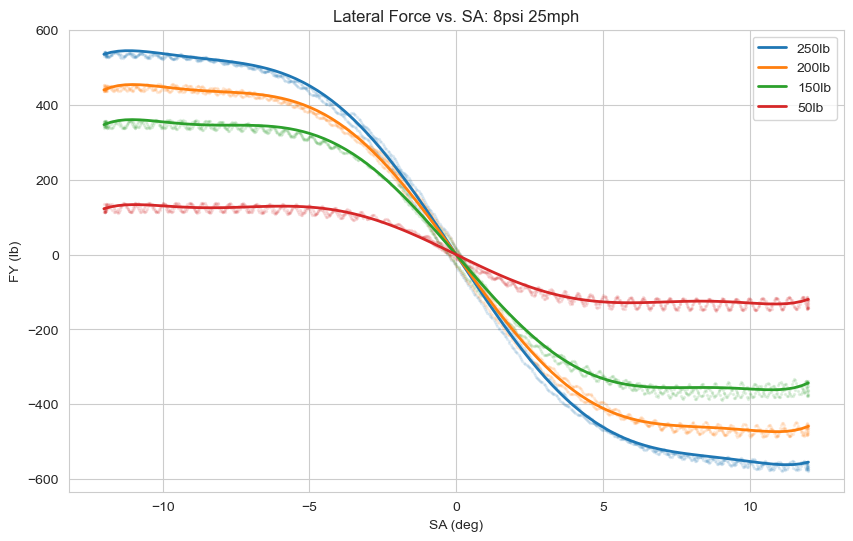

In [17]:
# one fitted example
plot_fitted_data(get_lat_fz_8psi(results[15]['df']),degree = 7)

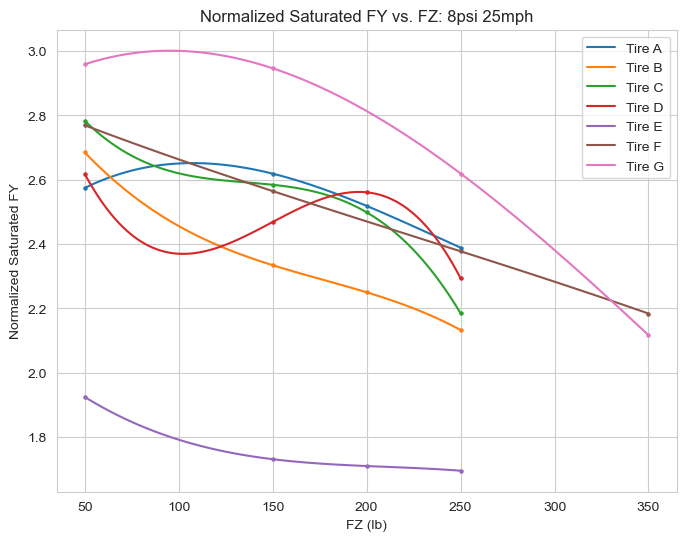

In [18]:
plot_saturated_lat_force(get_lat_fz_8psi(results[6]['df']),get_lat_fz_8psi(results[15]['df']),
                         get_lat_fz_8psi(results[32]['df']),get_lat_fz_8psi(results[38]['df']),
                         get_lat_fz_8psi(results[44]['df']),get_lat_fz_8psi(results[18]['df']),
                         get_lat_fz_8psi(results[24]['df']),
                         labels=Tire_Labels,
                         fz_ls = fz_ls, p = 8)

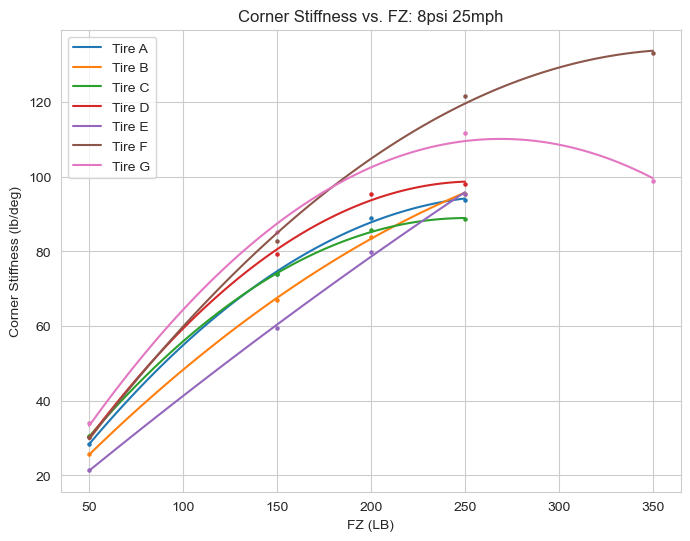

In [19]:
plot_corner_Stiffness(results[6]['slope'],results[15]['slope'],
                      results[32]['slope'],results[38]['slope'],
                      results[44]['slope'],results[18]['slope'],
                      results[24]['slope'],
                      labels=Tire_Labels,
                      fz_ls = fz_ls, p = 8)

another test sets

In [20]:
results_2 = {}

for run_number in [4,5]:
    file_path = f'{common_path_1to15}A2356raw{run_number}.dat'
    html_filename = f'plotly_combine_t{run_number}.html'
    df, slope = process_file(file_path, output_html=html_filename)
    results_2[run_number] = {'df': df, 'slope': slope}

for run_number in [14]:
    file_path = f'{common_path_1to15}A2356raw{run_number}.dat'
    html_filename = f'plotly_combine_t{run_number}.html'
    df, slope = process_file(file_path, output_html=html_filename, get_lat_fz = get_lat_fz_14psi)
    results_2[run_number] = {'df': df, 'slope': slope}

for run_number in [31,37,43,17,23]:
    file_path = f'{common_path_16to49}A2356raw{run_number}.dat'
    html_filename = f'plotly_combine_t{run_number}.html'
    df, slope = process_file(file_path, output_html=html_filename, get_lat_fz = get_lat_fz_14psi)
    results_2[run_number] = {'df': df, 'slope': slope}

In [21]:
# Handling an abort situation
df4 = results_2[4]['df']
df4 = df4[df4['ET (s)']<=1260]

df5 = results_2[5]['df']
df5 = df5[df5['ET (s)']>=169]

first_df5_values = df5['ET (s)'].iloc[0]
df5['ET (s)'] = df5['ET (s)'] - first_df5_values

last_et_value = df4['ET (s)'].iloc[-1]
df5['ET (s)'] = df5['ET (s)'] + last_et_value

df_4_5 = pd.concat([df4, df5], axis=0)
plotly_parameters_combine(df_4_5, html_filename='plotly_combine_t4&5.html')

slope_4_5 = slope_at_zero(get_lat_fz_14psi(df_4_5))

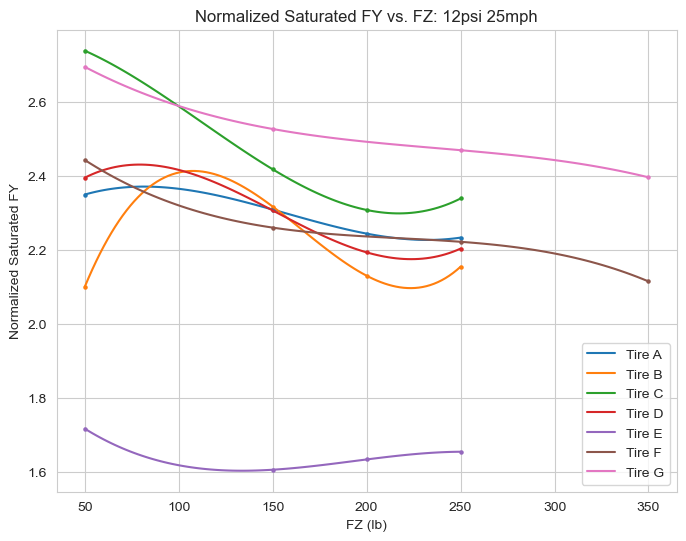

In [22]:
plot_saturated_lat_force(get_lat_fz_14psi(df_4_5),get_lat_fz_14psi(results_2[14]['df']),
                         get_lat_fz_14psi(results_2[31]['df']),get_lat_fz_14psi(results_2[37]['df']),
                         get_lat_fz_14psi(results_2[43]['df']),get_lat_fz_14psi(results_2[17]['df']),
                         get_lat_fz_14psi(results_2[23]['df']),
                         labels=Tire_Labels,
                         fz_ls = fz_ls, p = 12)

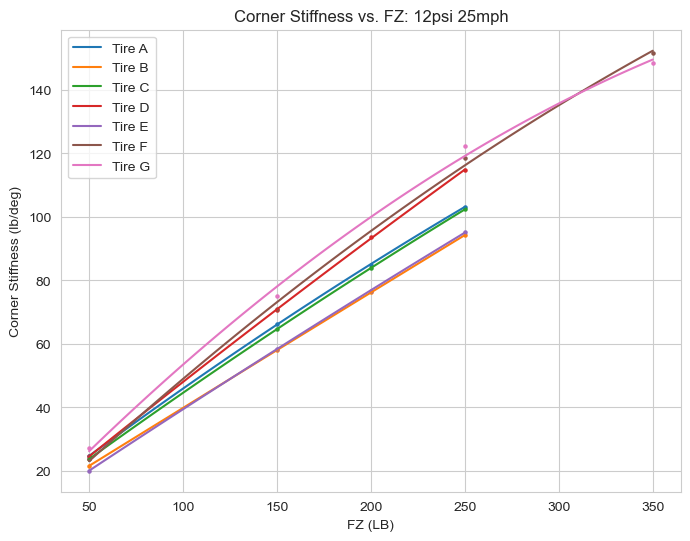

In [23]:
plot_corner_Stiffness(slope_4_5,results_2[14]['slope'],
                      results_2[31]['slope'],results_2[37]['slope'],
                      results_2[43]['slope'],results_2[17]['slope'],
                      results_2[23]['slope'],
                      labels=Tire_Labels,
                      fz_ls = fz_ls, p = 12)